In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys
import pandas as pd
from pathlib import Path

os.environ['pRT_input_data_path'] = os.path.join('/home/mvasist/pRT/input_data_v2.4.9/input_data')
from petitRADTRANS import nat_cst as nc

In [15]:
## observation
obsHST_file = Path('/home/mvasist/WISEJ1738/observation') / 'HST/WISEJ1738_HST.txt'
obs_hst_pd = pd.read_csv(obsHST_file, header=0, delimiter = ',')
obs_wlen_hst = np.array(obs_hst_pd.iloc[:,0])
obs_hst = np.array(obs_hst_pd.iloc[:, 1]*1e1*1e30 * (obs_wlen_hst*1e-4)**2/nc.c) 
sigmaH = np.array(obs_hst_pd.iloc[:,2]*1e1*1e30 * (obs_wlen_hst*1e-4)**2/nc.c)

obs_miri_pd = pd.read_csv('/home/mvasist/WISEJ1738/observation/MIRI/unconvolved/spectrum.csv')
obs_wlen_miri  = np.array(obs_miri_pd.iloc[:, 0])
obs_miri = np.array(obs_miri_pd.iloc[:, 1])
sigmaM = np.array(obs_miri_pd.iloc[:, 2])

## observation
obs_gemini_pd = pd.read_csv('/home/mvasist/WISEJ1738/observation/NIRGemini/spectrum_gemini.csv', float_precision='round_trip')
obs_wlen_gemini = obs_gemini_pd.iloc[:,0].values
obs_gemini = np.array(obs_gemini_pd.iloc[:, 1])
sigmaG = np.array(obs_gemini_pd.iloc[:, 2])

#scaling for distance for the NN
D = 7.34
obs_hst = obs_hst *1e5 * (D/9.9)**2  
sigmaH = sigmaH * (D/9.9)**2
obs_miri = obs_miri *1e5 * (D/9.9)**2
sigmaM = sigmaM * (D/9.9)**2
obs_gemini = obs_gemini *1e5 * (D/9.9)**2  
sigmaG = sigmaG * (D/9.9)**2

In [16]:
## observation

obs_miri_pd1 = pd.read_csv('/home/mvasist/WISEJ1738/observation/MIRI/unconvolved/spectrum_reprocessed231123.csv')
obs_wlen_miri1  = np.array(obs_miri_pd1.iloc[:, 0])
obs_miri1 = np.array(obs_miri_pd1.iloc[:, 1])
sigmaM1 = np.array(obs_miri_pd1.iloc[:, 2])

#scaling for distance for the NN
obs_miri1 = obs_miri1 *1e5 * (D/9.9)**2
sigmaM1 = sigmaM1 * (D/9.9)**2

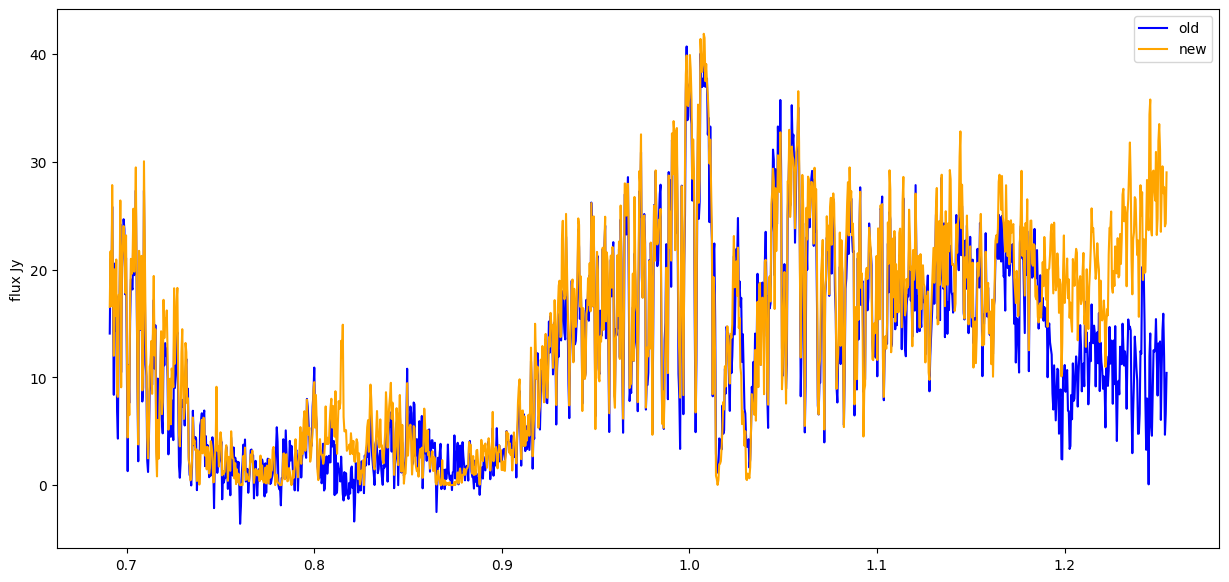

In [3]:
plt.figure(figsize=(15,7))
plt.plot(np.log10(obs_wlen_miri), obs_miri, color = 'blue', label = 'old')
plt.plot(np.log10(obs_wlen_miri1), obs_miri1,  color = 'orange', label = 'new')

plt.ylabel('flux Jy')
# plt.title('as the NN sees it')
plt.legend()
plt.show()

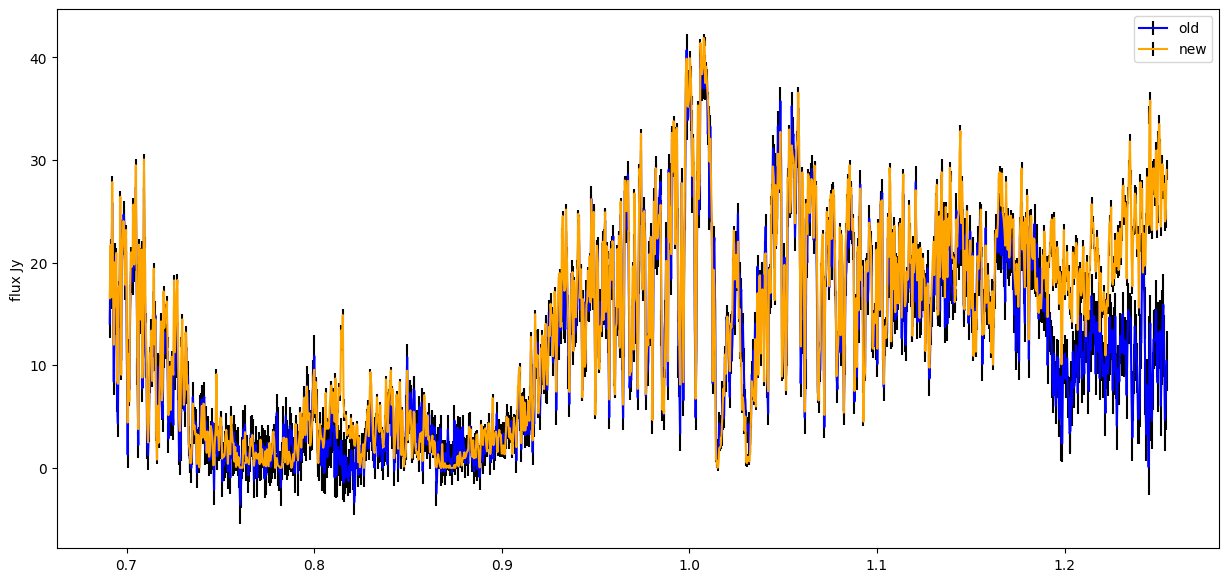

In [4]:
plt.figure(figsize=(15,7))
plt.errorbar(np.log10(obs_wlen_miri), obs_miri, yerr= sigmaM*1e5, color = 'blue', ecolor='black', label = 'old')
plt.errorbar(np.log10(obs_wlen_miri1), obs_miri1, yerr= sigmaM1*1e5, color = 'orange', ecolor='black', label = 'new')

plt.ylabel('flux Jy')
# plt.title('as the NN sees it')
plt.legend()
plt.show()

In [5]:
def plotting_zoomed_regions(mask):

    plt.figure(figsize=(15,7))
    plt.plot(np.log10(obs_wlen_miri)[mask], obs_miri[mask], color = 'blue', label = 'old')
    plt.plot(np.log10(obs_wlen_miri1)[mask], obs_miri1[mask],  color = 'orange', label = 'new')
    plt.legend()
    plt.show()

    plt.figure(figsize=(15,7))
    plt.errorbar(np.log10(obs_wlen_miri)[mask], obs_miri[mask], yerr= sigmaM[mask]*1e5, color = 'blue', ecolor='black', label = 'old')
    plt.errorbar(np.log10(obs_wlen_miri1)[mask], obs_miri1[mask], yerr= sigmaM1[mask]*1e5, color = 'orange', ecolor='black', label = 'new')

    plt.ylabel('flux Jy')
    plt.legend()
    plt.show()

## Zoomed in <0.9

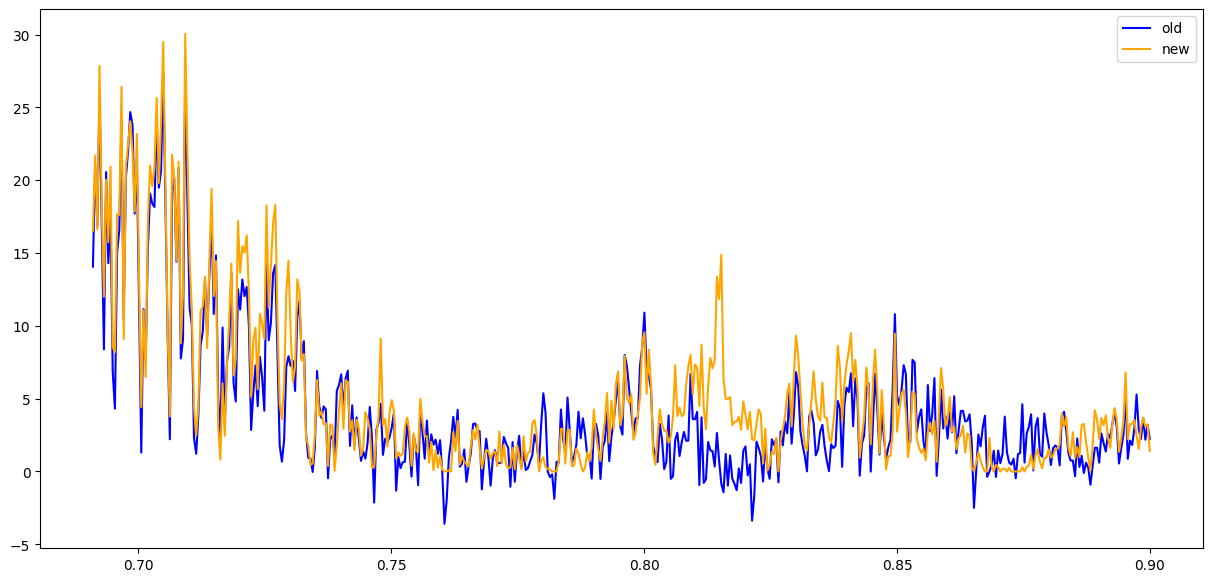

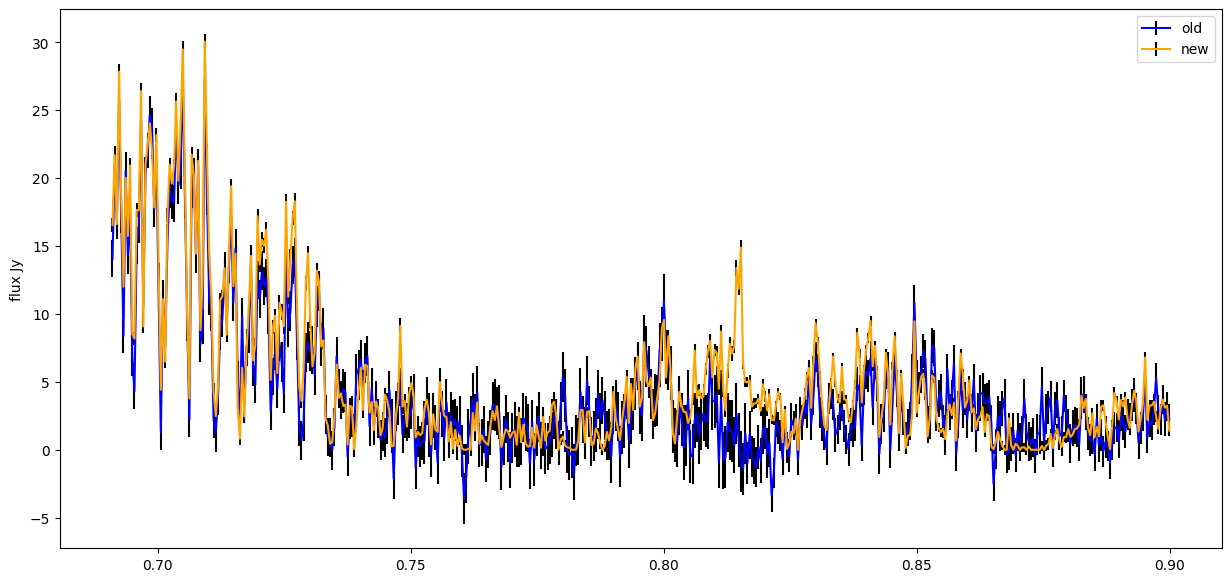

In [6]:
m1 = np.log10(obs_wlen_miri)<0.9

plotting_zoomed_regions(m1)

## Zoomed in x>1.1

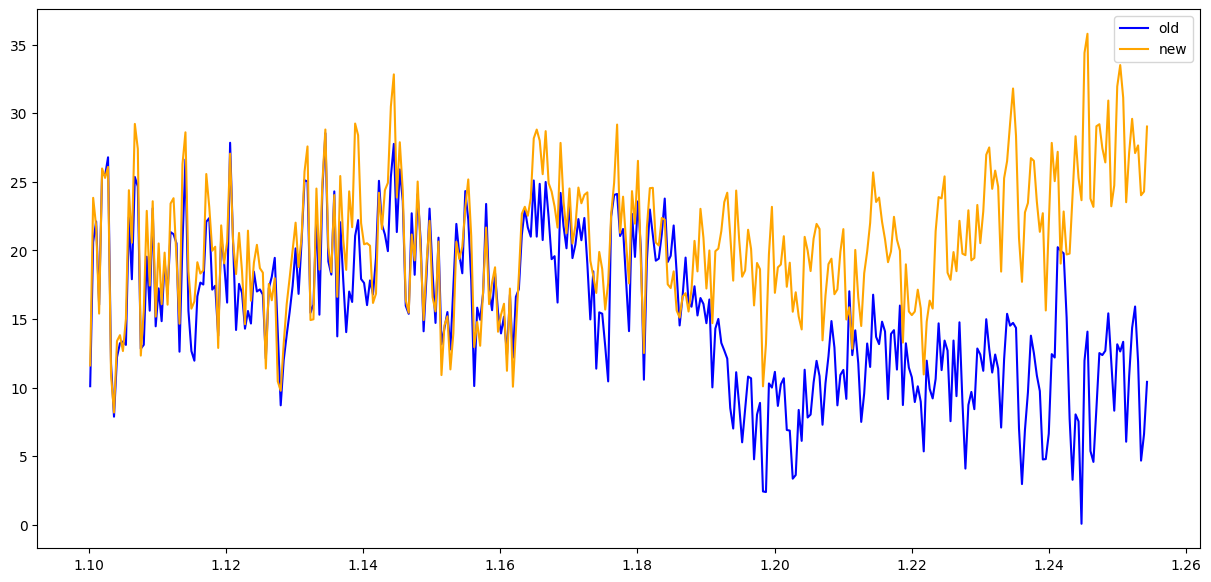

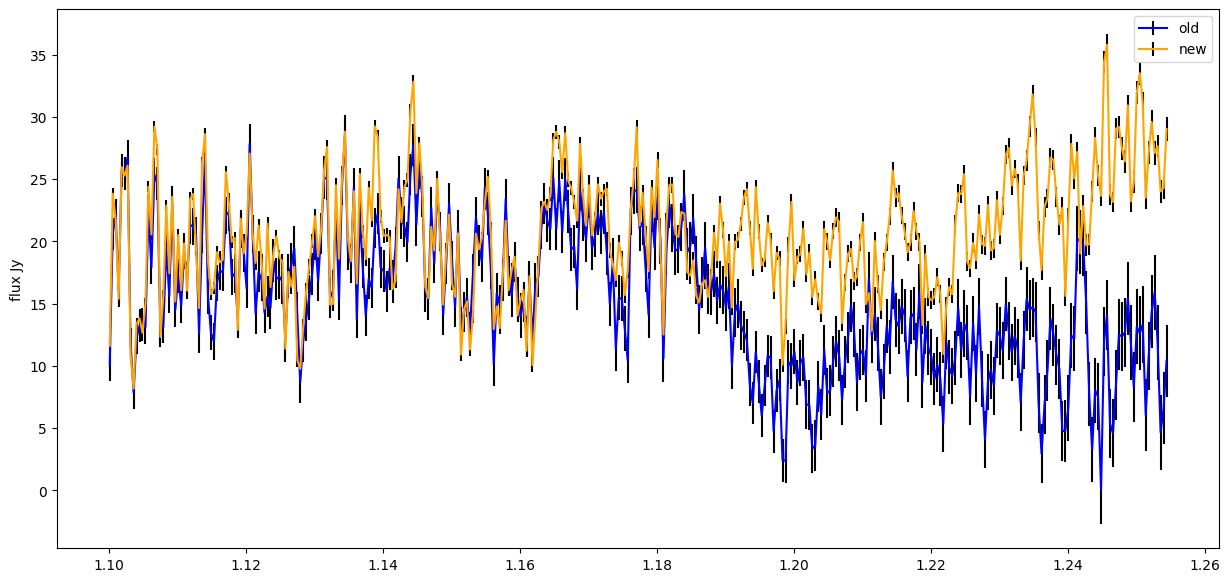

In [7]:
m2 = np.log10(obs_wlen_miri)>1.1

plotting_zoomed_regions(m2)

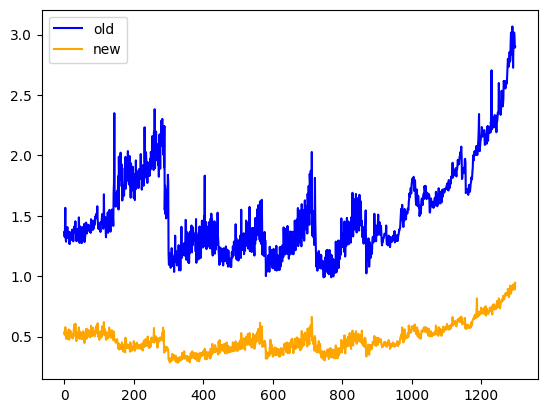

In [8]:
plt.plot(sigmaM*1e5, color = 'blue', label = 'old')
plt.plot(sigmaM1*1e5, color = 'orange', label = 'new')
plt.legend()
plt.show()

## Plotting with residuals

In [34]:
import sys
sys.path.insert(0, '/home/mvasist/WISEJ1738/sbi') #WISEJ1738/sbi
from ees import Simulator, emission_spectrum
import train_MIRI_Gemini_plotting
from added_scripts.corner_modified import *
from added_scripts.pt_plotting import *

from train_MIRI_Gemini_plotting import plots
scratch = os.environ.get('SCRATCH')

In [19]:
runpath = Path(scratch) / 'JWST/runs/WISEJ1738/model_15NH3HCNbfacM_unregPT/MIRI+Gemini/dry-forest-152'
epoch = 750

plot = plots(runpath, int(epoch/50) * 50)
savepath_plots = savepath_plots = runpath  / ('plots_' + str(epoch)+ '_reprocessed231123')
savepath_plots.mkdir(parents=True, exist_ok=True)
    
# cov_fig = plot.coverage(save= False)
# corner_fig = plot.cornerplot(save= False)
# fig_pt = plot.ptprofile(save= False)
# res_fig_miri = plot.consistencyplot_MIRI(save= False)
# res_fig_gemini = plot.consistencyplot_Gemini(save= False) #-- change simulator to plot again
# cornerWratio_fig = plot.cornerWratio(save= False)

In [27]:
# Simulator
simulator = Simulator(4.9, 19.0, noisy=False)
simulator_hst = Simulator(0.98, 2.2, noisy=False)

In [21]:
wlength = np.append(obs_wlen_gemini , obs_wlen_miri)
x_star = np.append(obs_gemini , obs_miri) 
theta = plot.sampling_from_post(torch.from_numpy(x_star).unsqueeze(0).float().cuda(), savepath_plots/'theta.csv', only_returning = True) #float()


In [22]:
theta.size()

torch.Size([1048576, 24])

In [29]:
def sim_spectra(theta, theta_name, x_name, only_returning = True, noisy = True):
        if not only_returning:
            x = np.stack([simulator(t) for t in tqdm(theta.numpy())])
            mask = ~np.isnan(x).any(axis=-1)
            mask1 = ~np.isinf(x[mask]).any(axis=-1)
            theta, x = theta[mask][mask1], x[mask][mask1]
            x = torch.from_numpy(x)
            x = x[:,1:1299]    # MIRI 

            if noisy :
                x, _ = noisybfactor(x, theta[:,-1], sigmaM)     # MIRI

            ## to save
            df_theta = pd.DataFrame(theta) #convert to a dataframe
            df_x = pd.DataFrame(x) #convert to a dataframe

            df_theta.to_csv(theta_name,index=False) #save to file
            df_x.to_csv(x_name,index=False) #save to file

        #Then, to reload:
        df_theta = pd.read_csv(theta_name)
        theta = df_theta.values
        df_x = pd.read_csv(x_name)
        x = df_x.values
        return torch.from_numpy(theta), torch.from_numpy(x)
        
theta_256_noisy, x_256_noisy = sim_spectra(theta[:2**9], savepath_plots /"theta_256_noisy_MIRI.csv", savepath_plots /"x_256_noisy_MIRI.csv", only_returning = True, noisy = True)
theta_256, x_256 = sim_spectra(theta[:2**9], savepath_plots /"theta_256_MIRI.csv", savepath_plots /"x_256_MIRI.csv", only_returning = True, noisy = False)
        


In [62]:
mask_ = torch.from_numpy(m1).expand(512,1298)

In [63]:
mask_.size()

torch.Size([512, 1298])

In [64]:
x_256_noisy.size()

torch.Size([512, 1298])

In [67]:
x_256_noisy[mask_]

IndexError: too many indices for tensor of dimension 2

In [50]:
def plotting_zoomed_regions_residuals(mask):
    
    mask_ = torch.from_numpy(mask).expand(512,1298).numpy()
    wlen = obs_wlen_miri
    def plottingres(residuals, name):

        fig, (ax1, ax2) = plt.subplots(2, figsize=(10,7), gridspec_kw={'height_ratios': [3, 1]})

        creds= [0.997, 0.955, 0.683]
        alpha = (0.0, 0.9)
        levels, creds = levels_and_creds(creds= creds, alpha = alpha)
        cmap= LinearAlphaColormap('steelblue', levels=creds, alpha=alpha)

        for q, l in zip(creds[:-1], levels):
            lower, upper = np.quantile(x_256_noisy[mask_].numpy(), [0.5 - q / 2, 0.5 + q / 2], axis=0)
            ax1.fill_between(wlen[mask], lower, upper, color= cmap(l), linewidth=0) #'C0', alpha=0.4,

        lines = ax1.plot(wlen[mask], obs_miri[mask], color='black', label = r'$ f(\theta_{obs})$', linewidth = 0.4)
        handles, texts = legends(axes= ax1, alpha=alpha) #0.15, 0.75
        texts = [r'$ f(\theta_{obs})$', r'$p_{\phi}(f(\theta)|x_{obs})$']
        plt.setp(ax1.get_xticklabels(), visible=False)
        ax1.set_ylabel(r'Planet flux $F_\nu$ (10$^{-5}$) Jy', fontsize = 10)
        ax1.legend(handles, texts, prop = {'size': 8}, bbox_to_anchor=(1,1))

        for q, l in zip(creds[:-1], levels):
            lower, upper = np.quantile(residuals[mask_], [0.5 - q / 2, 0.5 + q / 2], axis=0)
            ax2.fill_between(wlen[mask], lower, upper, color= cmap(l) , linewidth=0) #'C0', alpha=0.4
        ax2.set_ylabel(r'Residuals', fontsize = 10)
        ax2.set_xlabel( r'Wavelength ($\mu$m)', fontsize = 10)

# residuals = (x_256_noisy - obs_miri) / (sigmaM * simulator.scale)
# _ = plottingres(residuals, '_MIRI')

    _, sigma_new = train_MIRI_Gemini_plotting.noisybfactor(x_256, theta_256[:,-1], sigmaM)
    residuals_new = (x_256_noisy - obs_miri) / (sigma_new * simulator.scale)
    fig = plottingres(residuals_new, '_MIRI_new')


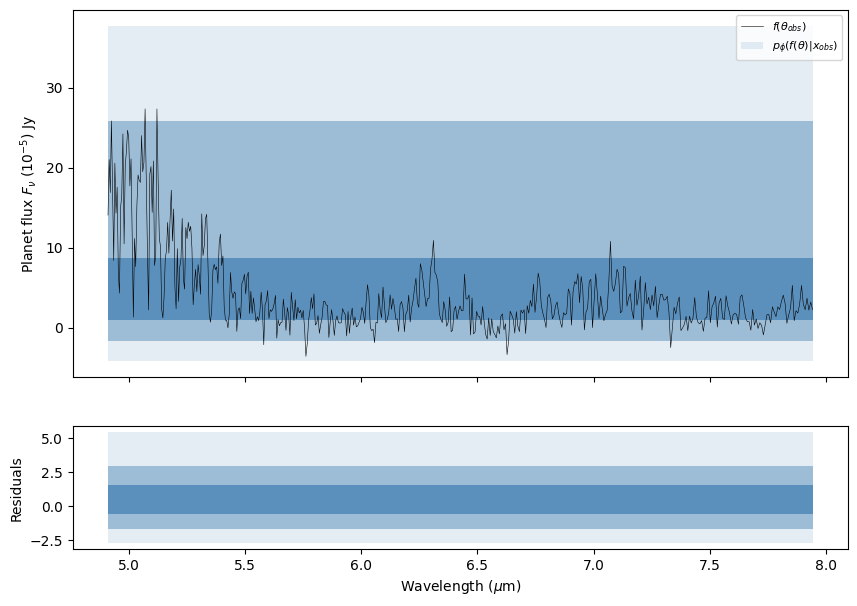

In [51]:
plotting_zoomed_regions_residuals(m1)

In [41]:
np.shape(m1)

(1298,)

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])